In [1]:
set.seed(100)
library(Rtsne)
library(ggplot2)
library(Seurat)
library(Matrix)
library(compare)
library(tictoc)
setwd("/projects/ucar-lab/danaco/PBMC_scRNAseqv/Default")


Attaching package: ‘compare’

The following object is masked from ‘package:base’:

    isTRUE



In [2]:
dat1_raw=read.table("./10-RNA.demux.filtered.VCF.best",header=TRUE,fill=TRUE)
drb <- strsplit(x = as.character(dat1_raw$BARCODE), split = "-")
drb  <- unlist(lapply(drb , `[[`, 1))
drb =paste("1-Sample",drb,sep="_")
dat1_raw$BARCODE=drb
dat2_raw=read.table("./2-RNA.demux.filtered.VCF.best",header=TRUE,fill=TRUE)
drb <- strsplit(x = as.character(dat2_raw$BARCODE), split = "-")
drb  <- unlist(lapply(drb , `[[`, 1))
drb =paste("2-Sample",drb,sep="_")
dat2_raw$BARCODE=drb
dat3_raw=read.table("./3-RNA.demux.filtered.VCF.best",header=TRUE,fill=TRUE)
drb <- strsplit(x = as.character(dat3_raw$BARCODE), split = "-")
drb  <- unlist(lapply(drb , `[[`, 1))
drb =paste("3-Sample",drb,sep="_")
dat3_raw$BARCODE=drb
dat4_raw=read.table("./4-RNA.demux.filtered.VCF.best",header=TRUE,fill=TRUE)
drb <- strsplit(x = as.character(dat4_raw$BARCODE), split = "-")
drb  <- unlist(lapply(drb , `[[`, 1))
drb =paste("4-Sample",drb,sep="_")
dat4_raw$BARCODE=drb
dat5_raw=read.table("./5-RNA.demux.filtered.VCF.best",header=TRUE,fill=TRUE)
drb <- strsplit(x = as.character(dat5_raw$BARCODE), split = "-")
drb  <- unlist(lapply(drb , `[[`, 1))
drb =paste("5-Sample",drb,sep="_")
dat5_raw$BARCODE=drb
dat6_raw=read.table("./6-RNA.demux.filtered.VCF.best",header=TRUE,fill=TRUE)
drb <- strsplit(x = as.character(dat6_raw$BARCODE), split = "-")
drb  <- unlist(lapply(drb , `[[`, 1))
drb =paste("6-Sample",drb,sep="_")
dat6_raw$BARCODE=drb
dat7_raw=read.table("./7-RNA.demux.filtered.VCF.best",header=TRUE,fill=TRUE)
drb <- strsplit(x = as.character(dat7_raw$BARCODE), split = "-")
drb  <- unlist(lapply(drb , `[[`, 1))
drb =paste("7-Sample",drb,sep="_")
dat7_raw$BARCODE=drb
dat8_raw=read.table("./8-RNA.demux.filtered.VCF.best",header=TRUE,fill=TRUE)
drb <- strsplit(x = as.character(dat8_raw$BARCODE), split = "-")
drb  <- unlist(lapply(drb , `[[`, 1))
drb =paste("8-Sample",drb,sep="_")
dat8_raw$BARCODE=drb
dat9_raw=read.table("./9-RNA.demux.filtered.VCF.best",header=TRUE,fill=TRUE)
drb <- strsplit(x = as.character(dat9_raw$BARCODE), split = "-")
drb  <- unlist(lapply(drb , `[[`, 1))
drb =paste("9-Sample",drb,sep="_")
dat9_raw$BARCODE=drb
dat10_raw=read.table("./1-RNA.demux.filtered.VCF.best",header=TRUE,fill=TRUE)
drb <- strsplit(x = as.character(dat10_raw$BARCODE), split = "-")
drb  <- unlist(lapply(drb , `[[`, 1))
drb =paste("10-Sample",drb,sep="_")
dat10_raw$BARCODE=drb


In [4]:
groundTruths_raw=read.csv("/home/danaco/Codes/ToyModels/CZI.PMBC.HTO.pooled.sample.classifications.GMM.csv")[,c(1,4)]

groundTruths_raw$Cell_Barcode=as.character(groundTruths_raw$Cell_Barcode)

immune_raw=rbind(dat1_raw,dat2_raw,dat3_raw,dat4_raw,dat5_raw,
                 dat6_raw,dat7_raw,dat8_raw,dat9_raw,dat10_raw)


SNG.BEST.LLK=immune_raw$SNG.NEXT.GUESS

SNG.BEST.LLK=immune_raw$SNG.NEXT.GUESS

immune=data.frame(BARCODE=immune_raw$BARCODE, NUM.READS=immune_raw$NUM.READS,DIFF.LLK.SNG.DBL=SNG.BEST.LLK
                  -immune_raw$DBL.BEST.LLK, DROPLET.TYPE=immune_raw$DROPLET.TYPE)
tic();
immune=merge(immune,groundTruths_raw,by.x="BARCODE",by.y="Cell_Barcode")
toc();

bcds=read.table("/projects/ucar-lab/danaco/Ground/comb.counts.barcodes.tsv")
bar_ids=which(immune$BARCODE %in% bcds$V1)
immune=immune[bar_ids,]

2.558 sec elapsed


In [4]:
#let's take the singlets only and fit a model
immuneSNG=subset(immune, DROPLET.TYPE=="SNG")
sng.m=lm(DIFF.LLK.SNG.DBL~NUM.READS,data=immuneSNG)

#let's take the doublets only and fit a model
immuneDBL=subset(immune, DROPLET.TYPE=="DBL")
dbl.m=lm(DIFF.LLK.SNG.DBL~NUM.READS,data=immuneDBL)

#let's take the doublets only and fit a model
immuneAMB=subset(immune, DROPLET.TYPE=="AMB")
amb.m=lm(DIFF.LLK.SNG.DBL~NUM.READS,data=immuneAMB)
dim(immuneAMB)[1]/dim(immune)[1]

[1] 0.2123591

Saving 6.67 x 6.67 in image


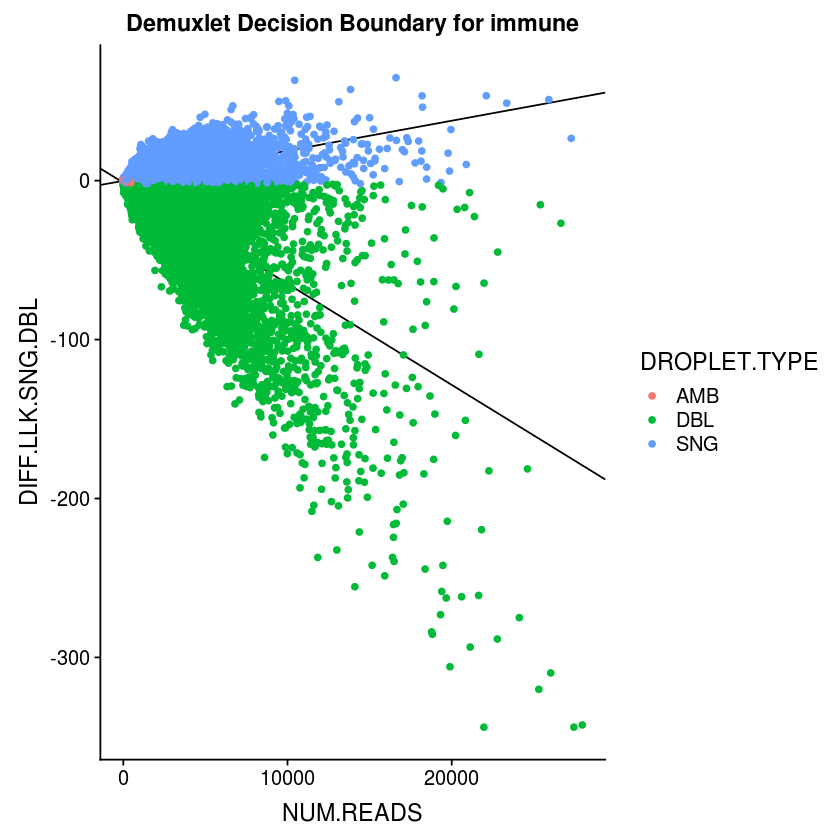

In [23]:
ggplot(aes(NUM.READS,DIFF.LLK.SNG.DBL,color=DROPLET.TYPE),data=immune)+
  geom_abline(slope=sng.m$coefficients[2],intercept=sng.m$coefficients[1])+
  geom_abline(slope=dbl.m$coefficients[2],intercept=dbl.m$coefficients[1])+
  geom_point()+ggtitle('Demuxlet Decision Boundary for immune')
ggsave("GroundTruths/immuneDecisionBoundary.png")

In [24]:
#let's estimate the NUM.READ densities for both singlets & doublets
#and let's take their singlet or doublet ratios
#i.e, estimated mixing proportions alpha.hat, 1-alpha.hat into account

alpha.sng.hat=dim(immuneSNG)[1]/dim(immune)[1]
alpha.dbl.hat=dim(immuneDBL)[1]/dim(immune)[1]
alpha.amb.hat=dim(immuneAMB)[1]/dim(immune)[1]

immune.dens=density(immune$NUM.READS)
sng.dens=density(immuneSNG$NUM.READS)
dbl.dens=density(immuneDBL$NUM.READS)
amb.dens=density(immuneAMB$NUM.READS)


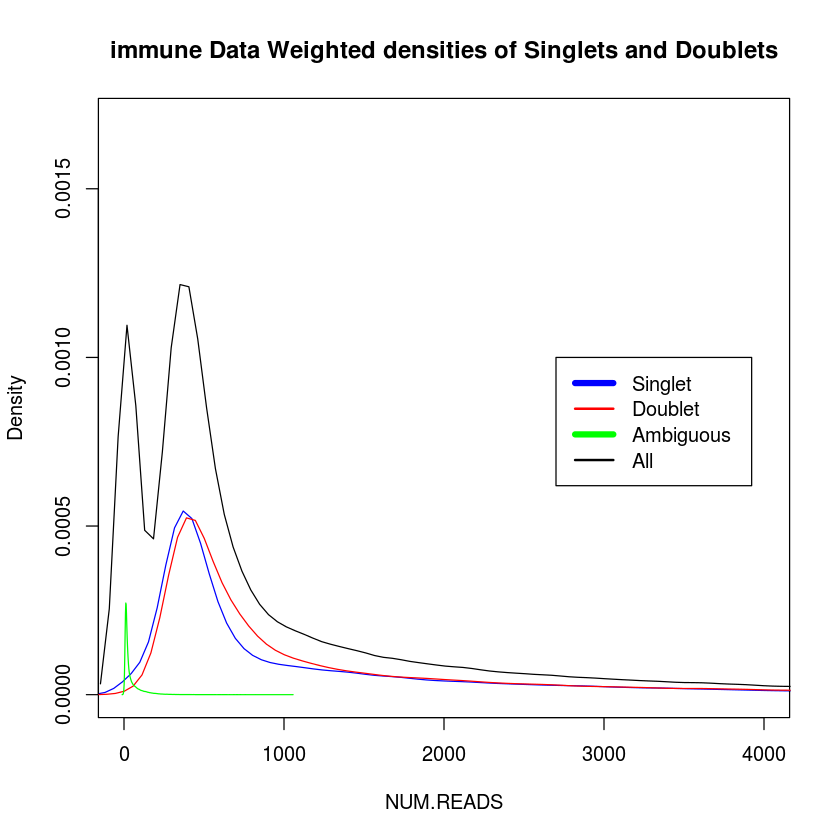

In [25]:
#png(filename="GroundTruths/immuneDensityFull.png")
plot(sng.dens$x,sng.dens$y*alpha.sng.hat,col="blue",
     type="l",xlab="NUM.READS",ylab="Density",xlim=c(0,4000),ylim=c(0,1.7e-3),
     main="immune Data Weighted densities of Singlets and Doublets")
lines(dbl.dens$x,dbl.dens$y*alpha.dbl.hat,col="red")
lines(amb.dens$x,dbl.dens$y*alpha.amb.hat,col="green")
lines(immune.dens,pch=4,cex=2,col="black")
legend(2700,1e-3,c("Singlet","Doublet","Ambiguous","All"), lwd=c(5,2),
       col=c("blue","red","green","black"))
#dev.off()

In [26]:
immune.1500=subset(immune, NUM.READS<1500)
immune.1500.SNG=subset(immune.1500, DROPLET.TYPE=="SNG")
immune.1500.DBL=subset(immune.1500, DROPLET.TYPE=="DBL")
immune.1500.AMB=subset(immune.1500, DROPLET.TYPE=="AMB")

Saving 6.67 x 6.67 in image


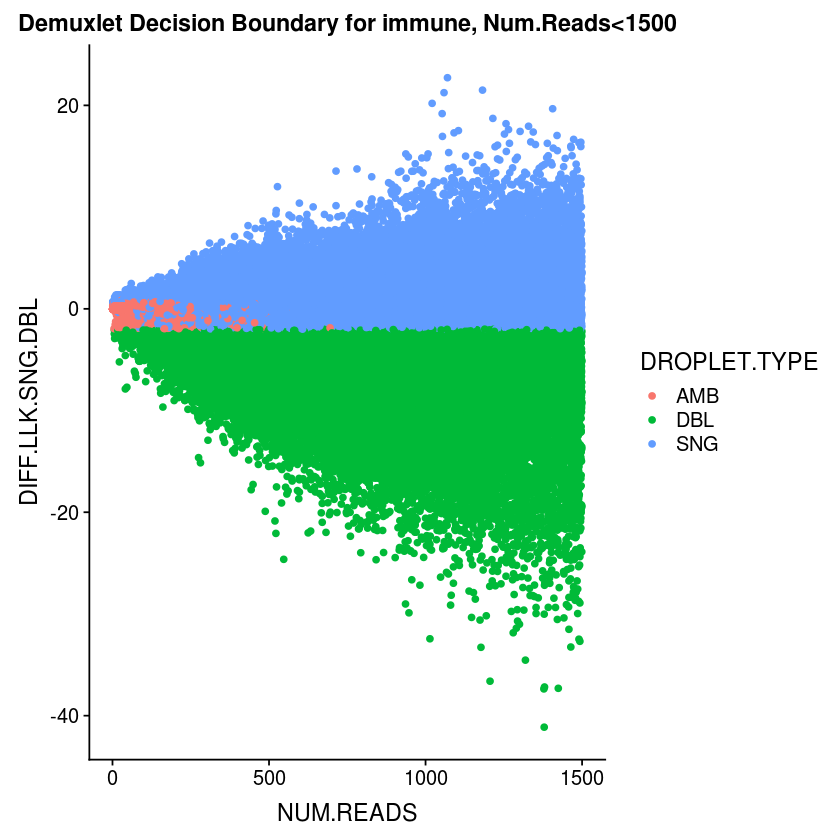

In [27]:
ggplot(aes(NUM.READS,DIFF.LLK.SNG.DBL,color=DROPLET.TYPE),data=immune.1500)+
  geom_point()+ggtitle('Demuxlet Decision Boundary for immune, Num.Reads<1500')
ggsave("GroundTruths/immuneDecisionBoundary1500.png")

In [30]:
alpha.1500.sng.hat=dim(immune.1500.SNG)[1]/dim(immune.1500)[1]
alpha.1500.dbl.hat=dim(immune.1500.DBL)[1]/dim(immune.1500)[1]
alpha.1500.amb.hat=dim(immune.1500.AMB)[1]/dim(immune.1500)[1]

immune.1500.dens=density(immune.1500$NUM.READS)
sng.1500.dens=density(immune.1500.SNG$NUM.READS)
dbl.1500.dens=density(immune.1500.DBL$NUM.READS)
amb.1500.dens=density(immune.1500.AMB$NUM.READS)



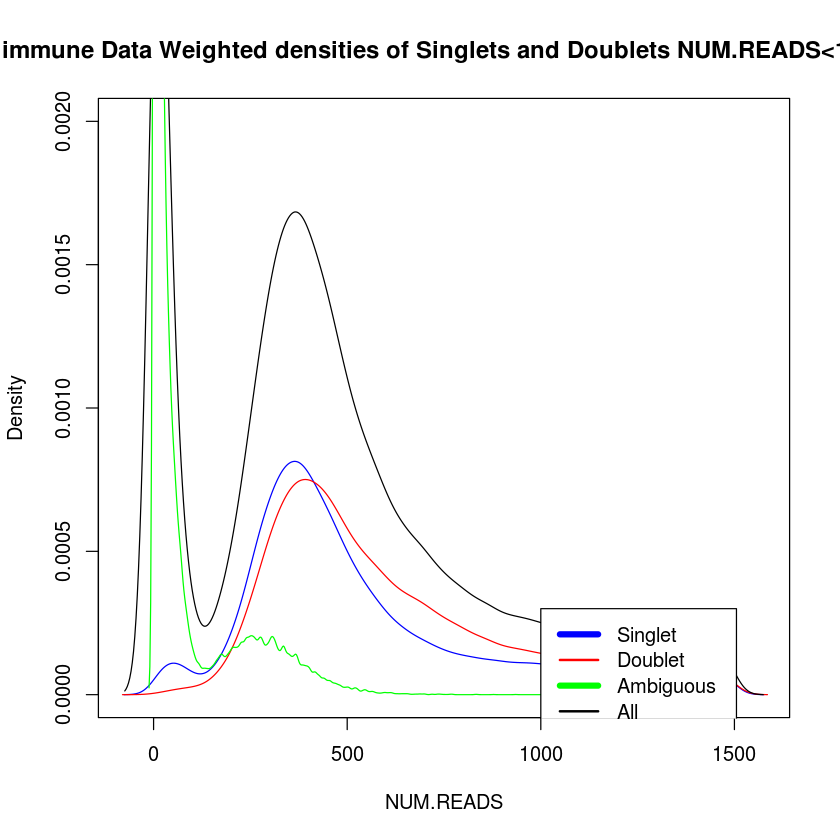

In [31]:
#png(filename="GroundTruths/immuneDensity1500.png",width=600)
plot(sng.1500.dens$x,sng.1500.dens$y*alpha.1500.sng.hat,col="blue",
     type="l",xlab="NUM.READS",ylab="Density",ylim=c(0,2e-3),
     main="immune Data Weighted densities of Singlets and Doublets NUM.READS<1500")
lines(dbl.1500.dens$x,dbl.1500.dens$y*alpha.1500.dbl.hat,col="red")
lines(amb.1500.dens$x,amb.1500.dens$y*alpha.1500.amb.hat,col="green")
lines(immune.1500.dens,pch=4,cex=2)
legend(1e3,3e-4,c("Singlet","Doublet","Ambiguous","All"), lwd=c(5,2),
       col=c("blue","red","green","black"))
#dev.off()

Saving 6.67 x 6.67 in image


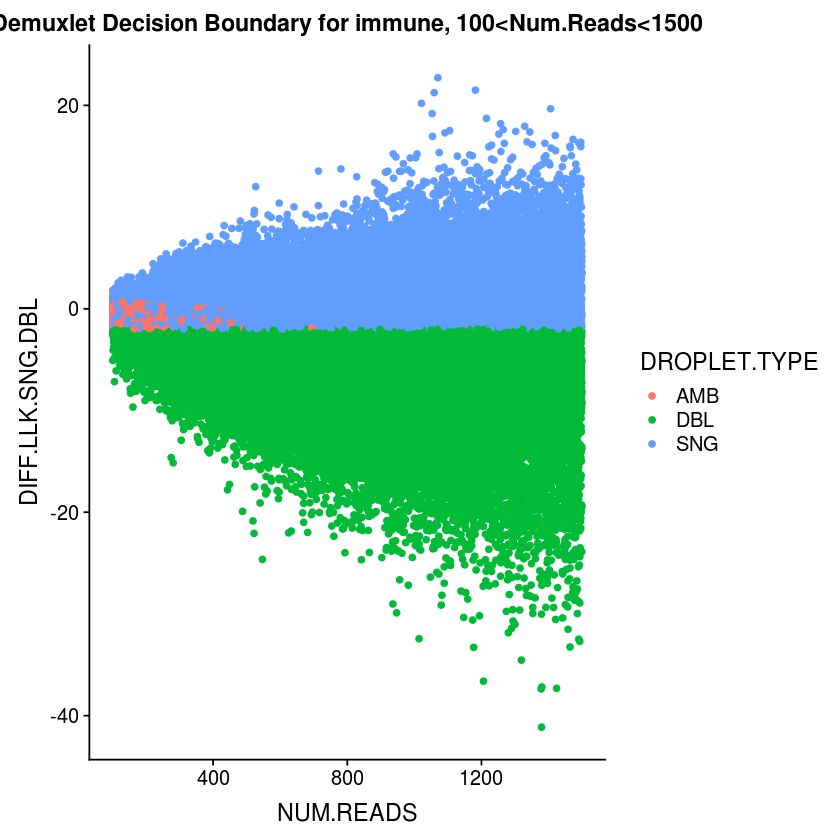

In [32]:
immune.1500.100=subset(immune.1500, NUM.READS>100)
immune.1500.100.SNG=subset(immune.1500.100, DROPLET.TYPE=="SNG")
immune.1500.100.DBL=subset(immune.1500.100, DROPLET.TYPE=="DBL")
immune.1500.100.AMB=subset(immune.1500.100, DROPLET.TYPE=="AMB")

ggplot(aes(NUM.READS,DIFF.LLK.SNG.DBL,color=DROPLET.TYPE),data=immune.1500.100)+
  geom_point()+ggtitle('Demuxlet Decision Boundary for immune, 100<Num.Reads<1500')
ggsave("GroundTruths/immuneDecisionBoundary1500_100.png")

In [33]:
alpha.1500.100.sng.hat=dim(immune.1500.100.SNG)[1]/dim(immune.1500.100)[1]
alpha.1500.100.dbl.hat=dim(immune.1500.100.DBL)[1]/dim(immune.1500.100)[1]
alpha.1500.100.amb.hat=dim(immune.1500.100.AMB)[1]/dim(immune.1500.100)[1]

immune.1500.100.dens=density(immune.1500.100$NUM.READS)
sng.1500.100.dens=density(immune.1500.100.SNG$NUM.READS)
dbl.1500.100.dens=density(immune.1500.100.DBL$NUM.READS)
amb.1500.100.dens=density(immune.1500.100.AMB$NUM.READS)

In [34]:
dim(subset(immune,NUM.READS>100))[1]/dim(immune)[1]

[1] 0.8194291

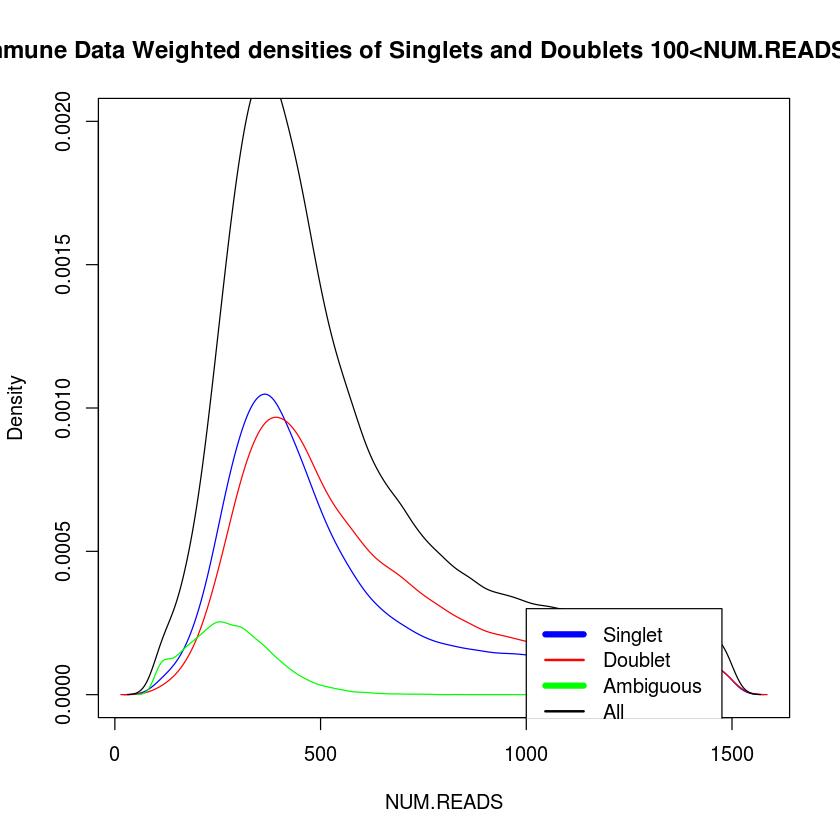

In [35]:
#png(filename="GroundTruths/immuneDensity1500_100.png",width=600)
plot(sng.1500.100.dens$x,sng.1500.100.dens$y*alpha.1500.100.sng.hat,col="blue",
     type="l",xlab="NUM.READS",ylab="Density",ylim=c(0,2e-3),
     main="immune Data Weighted densities of Singlets and Doublets 100<NUM.READS<1500")
lines(dbl.1500.100.dens$x,dbl.1500.100.dens$y*alpha.1500.100.dbl.hat,col="red")
lines(amb.1500.100.dens$x,amb.1500.100.dens$y*alpha.1500.100.amb.hat,col="green")
lines(immune.1500.100.dens,pch=4,cex=2)
legend(1e3,3e-4,c("Singlet","Doublet","Ambiguous","All"), lwd=c(5,2),
       col=c("blue","red","green","black"))
#dev.off()

In [36]:
sum(immuneSNG$DROPLET.TYPE==immuneSNG$S_type)/length(immune$S_type)

[1] 0.437291

In [5]:
immune.gr.SNG=subset(immune,S_type=="SNG")
immune.gr.DBL=subset(immune,S_type=="DBL")

In [13]:
length(which(immune.gr.SNG$DROPLET.TYPE=="AMB"))

[1] 29864

In [22]:
dim(immune.gr.DBL)[1]/dim(immune)[1]

[1] 0.3240479

In [50]:
grep(pattern="AAACCTGAGAATGTGT",x=groundTruths_raw$Cell_Barcode)

[1]      1 128855 193182

In [54]:
grep(pattern="AAACCTGAGACTGTAA",x=groundTruths_raw$Cell_Barcode)

[1]     2 32119 96579

In [137]:
groundTruths_raw$Cell_Barcode[96579]

[1] 3-Sample_AAACCTGAGACTGTAA
321887 Levels: 1-Sample_AAACCTGAGAATGTGT ... 9-Sample_TTTGTCATCTTGTTTG

In [62]:
as.character(dat1_raw$BARCODE[1
                ])

[1] "AAACCTGAGACTACAA-1"

In [75]:
veli=strsplit(x=as.character(dat1_raw$BARCODE[1]),split="-")

In [125]:
d1rb=dat1_raw$BARCODE
fun1=function(a){b=unlist(strsplit(x=as.character(a),split="-"));b[1]}
d1b=lapply(d1rb,fun1)

In [87]:
dat1_raw$BARCODE[2]

[1] AAACCTGAGACTGTAA-1
27410 Levels: AAACCTGAGACTACAA-1 AAACCTGAGACTGTAA-1 ... TTTGTCATCTGAGTGT-1

In [122]:
unlist(veli)[1]

[1] "AAACCTGAGACTACAA"

In [100]:
fun1(dat1_raw$BARCODE[2])

[1] "AAACCTGAGACTGTAA"

In [52]:
groundTruths_raw$Cell_Barcode[1]

[1] 1-Sample_AAACCTGAGAATGTGT
321887 Levels: 1-Sample_AAACCTGAGAATGTGT ... 9-Sample_TTTGTCATCTTGTTTG

In [142]:
rnk[1:3]

[1] "1-Sample_AAACCTGAGACTACAA" "1-Sample_AAACCTGAGACTGTAA"
[3] "1-Sample_AAACCTGAGAGCTTCT"

In [57]:
immune_raw$DROPLET.TYPE[310300] == groundTruths_raw$S_type[60701]

[1] TRUE

In [23]:
length(immune_raw$)
length(groundTruths_raw$Cell_Barcode)

[1] 313404

[1] 321887

In [156]:
grep(x=groundTruths_raw$Cell_Barcode,pattern="AAACCTGAGACTACAA")

[1] 32118

In [9]:
grep(x=immune_raw$BARCODE,pattern="CTGCTGTTCATACGGT")

[1]  14234 140722

In [58]:
typeof(immune_raw$BARCODE[260733])

[1] "character"

In [72]:
length(grep(x=groundTruths_raw$Cell_Barcode, pattern="10-Sampsle_TCTTTCCAGAATGTTG"))

[1] 0

In [56]:
typeof(groundTruths_raw$S_type[60701])

[1] "integer"

[1] 321887

[1] 83046.85

[1] 23.06857

TRUE

[1] "9-HTO_ATTATCCGTCTCCACT"

In [86]:
groundTruths_raw[1,]

Cell_Barcode,Sample,Sample_Short,S_type,TR_S_type,Run
1-Sample_AAACCTGAGAATGTGT,Mono,Mono,SNG,SNG,1-Sample


[1] 2028

0.279 sec elapsed


In [103]:
gt.raw.try=groundTruths_raw[1:10,]
im.raw.try=immune[1:5,]

In [104]:
merge(gt.raw.try,im.raw.try,by.x="Cell_Barcode",by.y="BARCODE")

Cell_Barcode,S_type,NUM.READS,DIFF.LLK.SNG.DBL,DROPLET.TYPE
1-Sample_AAACCTGAGAATGTGT,SNG,9,0.00,AMB
1-Sample_AAACCTGAGACTGTAA,DBL,64,0.05,AMB
1-Sample_AAACCTGAGATGCCAG,SNG,2,0.00,AMB
1-Sample_AAACCTGAGCAAATCA,DBL,2,0.00,AMB
1-Sample_AAACCTGAGCGTGAAC,SNG,2,0.00,AMB


In [90]:
gt.raw.try$Cell_Barcode

[1] "1-Sample_AAACCTGAGAATGTGT" "1-Sample_AAACCTGAGACTGTAA"
 [3] "1-Sample_AAACCTGAGATGCCAG" "1-Sample_AAACCTGAGCAAATCA"
 [5] "1-Sample_AAACCTGAGCGATATA" "1-Sample_AAACCTGAGCGTGAAC"
 [7] "1-Sample_AAACCTGAGCTAGCCC" "1-Sample_AAACCTGAGGAACTGC"
 [9] "1-Sample_AAACCTGAGGCTCAGA" "1-Sample_AAACCTGAGGGCTTCC"

In [92]:
im.raw.try$BARCODE

[1] "1-Sample_AAACCTGAGAATGTGT" "1-Sample_AAACCTGAGACTGTAA"
[3] "1-Sample_AAACCTGAGATGCCAG" "1-Sample_AAACCTGAGCAAATCA"
[5] "1-Sample_AAACCTGAGCGTGAAC"

In [99]:
groundTruths_raw$

Cell_Barcode,Sample,Sample_Short,S_type,TR_S_type,Run
1-Sample_AAACCTGAGAATGTGT,Mono,Mono,SNG,SNG,1-Sample
1-Sample_AAACCTGAGACTGTAA,Mono+Control,Doublet,DBL,DBL,1-Sample


In [106]:
dim(immune)
dim(immune_raw)
dim(groundTruths_raw)

[1] 313404      5

[1] 313404     19

[1] 321887      2

In [122]:
max(immune$NUM.READS)

[1] 27949

In [110]:
sum(immune$DROPLET.TYPE==immune$S_type)/dim(immune)[1]

[1] 0.3753685

In [117]:
immune.gr.500=subset(immune, NUM.READS>500)


sum(immune.gr.500$DROPLET.TYPE==immune.gr.500$S_type)/dim(immune.gr.500)[1]

[1] 0.5727544

In [127]:
bench.list=c()
dens.list=c()
xx=seq(1,max(immune$NUM.READS),length=100)
for (ii in xx){
    immune.gr.x=subset(immune, NUM.READS>ii)
    tmp=sum(immune.gr.x$DROPLET.TYPE==immune.gr.x$S_type)/dim(immune.gr.x)[1]
    bench.list=append(bench.list,tmp,after=length(bench.list))
    dens.list=append(dens.list,dim(immune.gr.x)[1]/dim(immune)[1],after=length(dens.list))
}

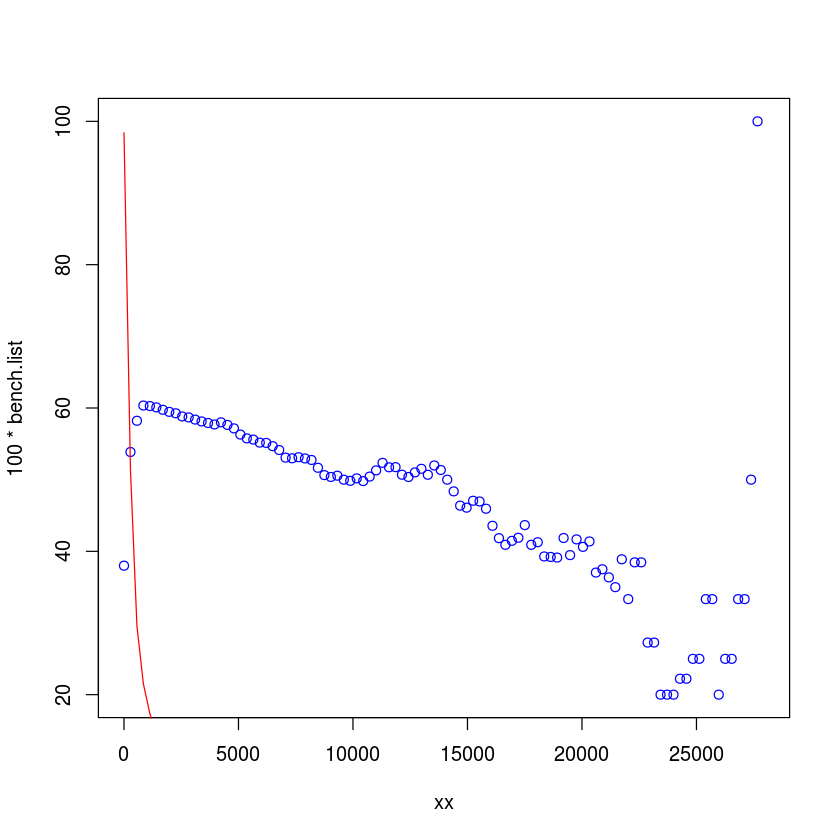

In [128]:
#png(filename="GroundTruths/immuneDensity1500_100.png",width=600)
plot(xx,100*bench.list,col="blue",
     type="l",xlab="NUM.READS Greater Than",ylab="Percentage",
     main="Demuxlet Precision for ",col="blue")
lines(xx,100*dens.list,col="red")
legend(10,3000,c("Singlet","Doublet","Ambiguous","All"), lwd=c(5,2),
       col=c("blue","red"))
#dev.off()

#plot(xx,100*bench.list,col="blue")
#lines(xx,100*dens.list,col="red")

In [17]:
dim(subset(immune,S_type=="AMB"))[1]/dim(immune)[1]
dim(subset(immune,S_type=="DBL"))[1]/dim(immune)[1]

immune.clean=subset(immune,S_type!="AMB")
dim(subset(immune.clean,S_type=="DBL"))[1]/dim(immune.clean)[1]


[1] 0.05619903

[1] 0.2598659

[1] 0.2753397

In [20]:
typeof(immune.clean$BARCODE[1
                    ])

[1] "integer"

In [5]:
bcds=read.table("/projects/ucar-lab/danaco/Ground/comb.counts.barcodes.tsv")
bar_ids=which(immune$BARCODE %in% bcds$V1)
immune=immune[bar_ids,]

In [5]:
groundTruth=data.frame(BARCODE=immune$BARCODE,S_type=immune$S_type)

In [8]:
write.csv(groundTruth, file = "/projects/ucar-lab/danaco/Ground/groundTruth.csv")


In [15]:
gg=read.csv("/projects/ucar-lab/danaco/Ground/groundTruth.csv")

In [16]:
write.csv(data.frame(BARCODE=immune$BARCODE,DROPLET.TYPE=immune$DROPLET.TYPE), 
          file = "/projects/ucar-lab/danaco/Ground/DemuxletDefaultLabels.csv")

In [ ]:
immune$DROPLET.TYPE